In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Resnet50 Pretrained Model

1/1 [==============================] - 1s 1s/step


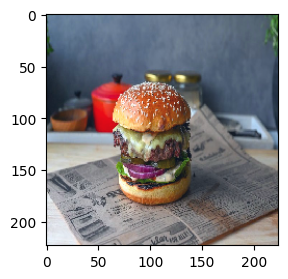

('n07697313', 'cheeseburger', 0.8156754)
('n02948072', 'candle', 0.037731446)
('n07745940', 'strawberry', 0.02414048)
('n12998815', 'agaric', 0.022062587)
('n07693725', 'bagel', 0.018543476)


In [81]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
import tensorflow.keras.utils as image
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2

def predict_class(_img):
    # preprocess image for the ResNet50 model
    _img = preprocess_input(_img)
    return resnet_model.predict(_img[np.newaxis, ...])

# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet')

# Load an image file
img = image.load_img('bur.jpg', target_size=(224, 224))
img = image.img_to_array(img)

# Use the ResNet50 model to make a prediction on the image
preds = predict_class(img)
decoded_preds = decode_predictions(preds, top=5)[0]

# Print the top 5 predicted classes and their associated probabilities
plt.figure(figsize=(3,3))
plt.imshow(((img[0:-1]) / 255) + 0.5)
plt.show()
for x in decode_predictions(preds)[0]:
    print(x)


In [76]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

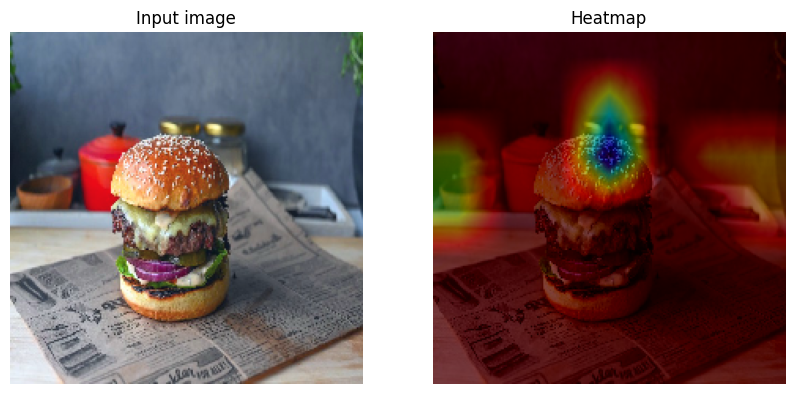

In [86]:
# GradCam Test
def get_heatmap(img_array, class_index, model):
    # Reshape the image array to (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Create a new model that outputs the last convolutional layer and the output
    last_conv_layer = model.get_layer('conv5_block3_out')
    new_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

    # Get the gradient of the output with respect to the last convolutional layer
    with tf.GradientTape() as tape:
        conv_output, preds = new_model(img_array)
        output_class = preds[:, class_index]

    grads = tape.gradient(output_class, conv_output)

    # Get the mean gradient across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the activations of the last convolutional layer
    last_conv_layer_output = conv_output[0]

    # Multiply each channel by its corresponding gradient
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU and normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

# Get the heatmap for the predicted class
class_index = np.argmax(preds)
heatmap = get_heatmap(img, class_index, resnet_model)

# Resize the heatmap to be the same size as the input image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Apply a color map to the heatmap and overlay it on the input image
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img.astype('float32')/255., 0.5, heatmap.astype('float32')/255., 0.5, 0, dtype=cv2.CV_32F)

# Plot the heatmap and the input image with the heatmap overlayed
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img/255 + 0.5)
plt.title('Input image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title('Heatmap')
plt.axis('off')
plt.show()